In [26]:
"""Does statistical analysis"""
from typing import List, Tuple
import datetime
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype
import numpy as np
# import time_series_correlation
#Open charts in new windows
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter #To avoid scientific notation

COMMENTS_DATA = "wallstreetbets-posts-and-comments-for-august-2021-comments.csv"
STOCK_DATA = ""

In [35]:
def get_comments() -> pd.DataFrame:
    """Returns a dataframe of the commment table. It has the timestamp, comment body and sentiment scores.
    Records without a """
    df = pd.read_csv("wallstreetbets-posts-and-comments-for-august-2021-comments 1.csv")
    df['datetime'] = pd.to_datetime(df.created_utc, unit='s').dt.tz_localize('UTC') #get timestamps
    df.set_index('datetime', inplace=True)
    df = df[['body', 'sentiment']] #pick certain columns
    df =  df[df.sentiment.notna()] #extract rows with existing sentiment scores
    
    gme_mentions = df.body.str.contains("GME", case=False)
    gamestop_mentions = df.body.str.contains("gamestop", case=False)
    return df[gamestop_mentions | gme_mentions]

def get_stock_data() -> pd.DataFrame:
    df = pd.read_csv("alphavantage_data_GME_2021-08.csv")
    df['datetime'] = pd.to_datetime(df.timestamp)
    return df.set_index('datetime')

In [28]:
#Basic column extraction
def comment_sentiment(comments : pd.DataFrame) -> pd.Series:
    """Returns a series object that contains the sentiment of each comment"""
    return comments.sentiment

def stock_price(stock_data : pd.Series) -> pd.Series:
    """Returns a series object for the opening price of the stock data"""
    return stock_data.open

def stock_volume(stock_data : pd.Series) -> pd.Series:
    """Returns a series object for the traded volume of the stock"""
    return stock_data.volume


In [45]:
#Higher level processing
def chat_velocity(sentiment : pd.Series) -> pd.Series:
    """Group comment count into 5min intervals, returns a Series object"""
    velocity = sentiment.resample('5min').size()
    velocity.name = "Chat Velocity"
    return velocity

def log_normal(series : pd.Series) -> pd.Series:
    """Performs log(x_n+1/x_n) on each item"""
    k = series.pct_change(1)
    k.apply(lambda x : np.log(x+1))
    return k

In [30]:
def plotTwoSeries(red : pd.Series, blue : pd.Series) -> None:
    """Plots both the given series. Both series need to have an datetime index"""
    fig, red_ax = plt.subplots()
    blue_ax = red_ax.twinx()

    plt.ticklabel_format(style='plain')
    red_plot, = red_ax.plot(red, color='red', label=red.name)
    blue_plot, = blue_ax.plot(blue, color='blue', label=blue.name)

    red_ax.xlabel = 'Time'
    red_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True)) #TODO: Add a y-axis limit at 0?
    blue_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    red_ax.set(ylabel=red.name)
    blue_ax.set(ylabel=blue.name)

    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')
    plt.title(f"{red.name} vs {blue.name}")
    plt.legend(handles=[red_plot, blue_plot])
    plt.show()

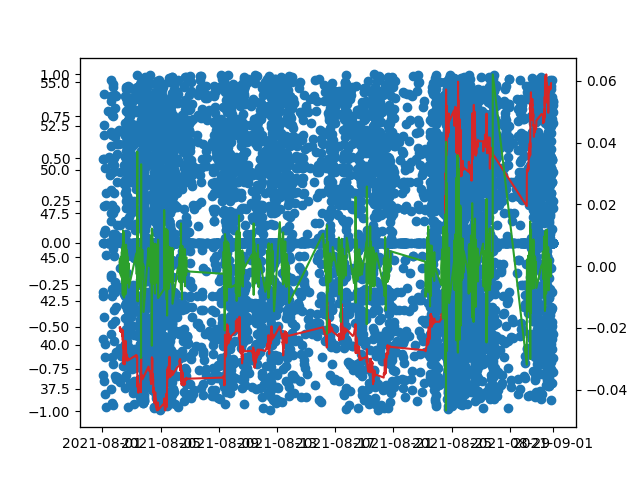

In [32]:
#Sentiment of each comment and  market price against time, in August 2021
fig, comments_ax = plt.subplots()
sentiment = comment_sentiment(get_comments())
#print(get_sentiment().columns)
comments_ax.scatter(sentiment.index,sentiment.values)#,x='datetime', y='values')
stocks_ax = comments_ax.twinx()
change_ax = stocks_ax.twinx()
prices = stock_price(get_stock_data())
stocks_ax.plot(prices, color='tab:red')
logged = log_normal(prices)
change_ax.plot(logged, color ='tab:green')
plt.show()

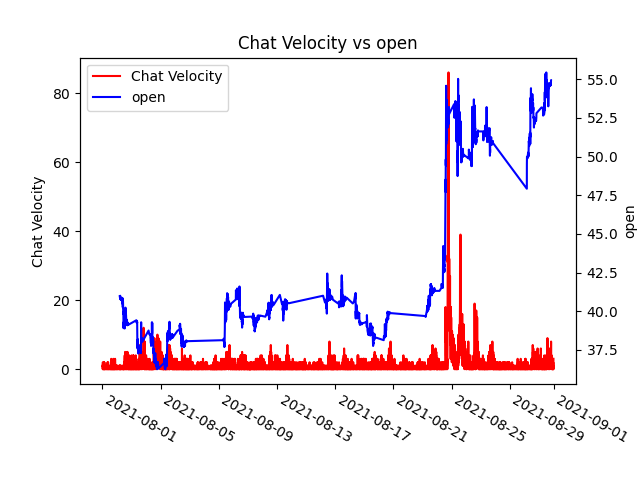

In [46]:
#Plot comment frequency against market price, in August 2021
plotTwoSeries(chat_velocity(comment_sentiment(get_comments())), stock_price(get_stock_data()))

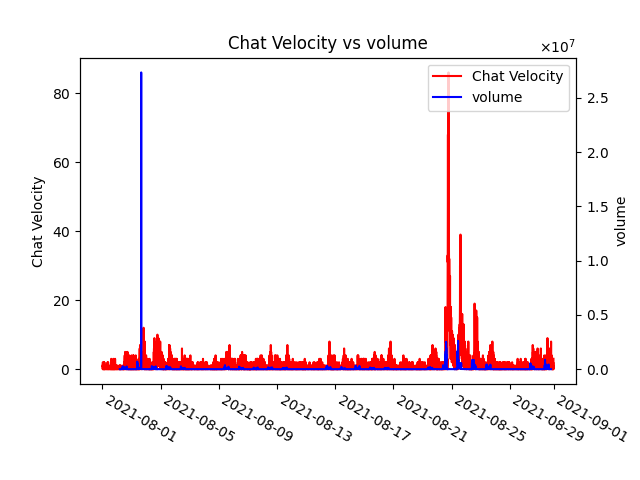

In [47]:
#Plot chat velocity against traded volume, in August 2021
plotTwoSeries(chat_velocity(comment_sentiment(get_comments())), stock_volume(get_stock_data()))